In [1]:
from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.distributions.multivariate_normal import MultivariateNormal
from sklearn.linear_model import BayesianRidge
from scipy.stats import multivariate_normal, sem

from experiments.linear_regression_posterior import (
    get_features_and_targets, 
    compute_true_posterior,
    build_model_and_callbacks,
    fit_model,
)
from experiments.utils.metrics import compute_distance_between_matrices, compute_gaussian_wasserstein_distance
from swafa.fa import OnlineEMFactorAnalysis

np.set_printoptions(suppress=True) # don't use scientific notation

%load_ext autoreload
%autoreload 2

### Define parameters

In [96]:
# data
n_samples, n_features = 1000, 2
feature_covar = [
    [1, 0.5], 
    [0.5, 1]
]
alpha = 0.01
beta = 0.1
lambda_ = alpha / beta

# callbacks
latent_dim = 1
gradient_weight_posterior_kwargs = dict(
    latent_dim=latent_dim,
    optimiser=SGD,
    optimiser_kwargs=dict(lr=0.001),
    n_warm_up_time_steps=100,
    random_seed=1,
)
em_weight_posterior_kwargs = dict(
    latent_dim=latent_dim,
    n_warm_up_time_steps=100,
    random_seed=1,
)
posterior_update_epoch_start = 1
posterior_eval_epoch_frequency = 100000

# training
batch_size = 100
pre_train_lr = 1e-3
pre_train_n_epochs = 500

swa_lr = 1.6e-1
swa_weight_decay = 1e-3
swa_n_epochs = 100

### Define helper functions

In [97]:
def run_experiment(n_samples: int, n_features: int, feature_covar: np.ndarray, alpha: float, beta: float, 
                   latent_dim: int, gradient_weight_posterior_kwargs: dict, em_weight_posterior_kwargs: dict, 
                   posterior_update_epoch_start: int, posterior_eval_epoch_frequency: int, batch_size: int,
                   pre_train_lr: float, pre_train_n_epochs: int, swa_lr: float, swa_weight_decay: float,
                   swa_n_epochs: int, n_trials: int) -> (List[float], List[float], List[float]):
    
    relative_distances_from_mean = []
    relative_distances_from_cov = []
    wasserstein_distances = []
    for n in range(n_trials):
        results = run_trial(
            n_samples=n_samples, 
            n_features=n_features, 
            feature_covar=feature_covar, 
            alpha=alpha, 
            beta=beta, 
            latent_dim=latent_dim, 
            gradient_weight_posterior_kwargs=gradient_weight_posterior_kwargs, 
            em_weight_posterior_kwargs=em_weight_posterior_kwargs, 
            posterior_update_epoch_start=posterior_update_epoch_start, 
            posterior_eval_epoch_frequency=posterior_eval_epoch_frequency, 
            batch_size=batch_size,
            pre_train_lr=pre_train_lr, 
            pre_train_n_epochs=pre_train_n_epochs, 
            swa_lr=swa_lr, 
            swa_weight_decay=swa_weight_decay,
            swa_n_epochs=swa_n_epochs, 
            random_seed=n
        )
        
        relative_distances_from_mean.append(
            compute_distance_between_matrices(
                results['true_posterior_mean'], 
                results['empirical_mean'],
            ) /
            compute_distance_between_matrices(
                results['true_posterior_mean'], 
                torch.zeros_like(results['true_posterior_mean']),
            )
        )
        
        relative_distances_from_cov.append(
            compute_distance_between_matrices(
                results['true_posterior_covar'], 
                results['empirical_covar'],
            ) /
            compute_distance_between_matrices(
                results['true_posterior_covar'], 
                torch.zeros_like(results['true_posterior_covar']),
            )
        )
        
        wasserstein_distances.append(
            compute_gaussian_wasserstein_distance(
                mean1=results['true_posterior_mean'], 
                covar1=results['true_posterior_covar'], 
                mean2=results['empirical_mean'], 
                covar2=results['empirical_covar'],
            )
        )
        
    return relative_distances_from_mean, relative_distances_from_cov, wasserstein_distances


def run_trial(n_samples: int, n_features: int, feature_covar: np.ndarray, alpha: float, beta: float, 
              latent_dim: int, gradient_weight_posterior_kwargs: dict, em_weight_posterior_kwargs: dict, 
              posterior_update_epoch_start: int, posterior_eval_epoch_frequency: int, batch_size: int,
              pre_train_lr: float, pre_train_n_epochs: int, swa_lr: float, swa_weight_decay: float,
              swa_n_epochs: int, random_seed: int) -> dict:
    X, y = generate_data(n_samples, n_features, feature_covar, random_seed)
    
    true_posterior_mean, true_posterior_covar, _, _ = compute_true_posterior(X, y, alpha=alpha, beta=beta)
    
    (
        model,
        gradient_posterior_update_callback,
        em_posterior_update_callback,
        sklearn_posterior_eval_callback,
        gradient_posterior_eval_callback,
        em_posterior_eval_callback,
    ) = build_model_and_callbacks(
        X=X,
        true_posterior_mean=true_posterior_mean,
        true_posterior_covar=true_posterior_covar,
        model_optimiser_class=SGD,
        model_optimiser_kwargs=None,
        posterior_latent_dim=latent_dim,
        gradient_weight_posterior_kwargs=gradient_weight_posterior_kwargs,
        em_weight_posterior_kwargs=em_weight_posterior_kwargs,
        posterior_update_epoch_start=posterior_update_epoch_start,
        posterior_eval_epoch_frequency=posterior_eval_epoch_frequency,
        model_random_seed=random_seed,
    )

    callbacks = [
        gradient_posterior_update_callback,
        em_posterior_update_callback,
        sklearn_posterior_eval_callback,
        gradient_posterior_eval_callback,
        em_posterior_eval_callback,
    ]
    
    model.optimiser_kwargs = dict(lr=pre_train_lr)
    fit_model(X=X, y=y, model=model, callbacks=None, n_epochs=pre_train_n_epochs, batch_size=batch_size)
    w_pretrained = torch.clone(model.output_layer.weight.data).numpy().squeeze()
    
    model.optimiser_kwargs = dict(lr=swa_lr, weight_decay=swa_weight_decay)
    fit_model(X=X, y=y, model=model, callbacks=callbacks, n_epochs=swa_n_epochs, batch_size=batch_size)
    
    empirical_mean, empirical_covar = sklearn_posterior_eval_callback.get_empirical_mean_and_covariance()
    W = np.vstack(sklearn_posterior_eval_callback.weight_iterates)
    
    return dict(
        W=W,
        w_pretrained=w_pretrained, 
        true_posterior_mean=true_posterior_mean, 
        true_posterior_covar=true_posterior_covar,
        empirical_mean=empirical_mean,
        empirical_covar=empirical_covar,
    )
    
    
def generate_data(n_samples: int, n_features: int, feature_covar: np.ndarray, random_seed: int,
                  ) -> (np.ndarray, np.ndarray):
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

    p_x = MultivariateNormal(loc=torch.zeros(n_features), covariance_matrix=torch.Tensor(feature_covar))
    X = p_x.sample((n_samples,))

    p_theta = MultivariateNormal(loc=torch.zeros(n_features), covariance_matrix=torch.eye(n_features) / alpha)
    theta = p_theta.sample().reshape(-1, 1)

    epsilon = torch.normal(torch.zeros(n_samples), 1 / np.sqrt(beta) * torch.ones(n_samples))
    y = X.mm(theta).squeeze() + epsilon
    
    return X, y

### Run experiment

In [98]:
relative_distances_from_mean, relative_distances_from_cov, wasserstein_distances = run_experiment(
    n_samples=n_samples, 
    n_features=n_features, 
    feature_covar=feature_covar, 
    alpha=alpha, 
    beta=beta, 
    latent_dim=latent_dim, 
    gradient_weight_posterior_kwargs=gradient_weight_posterior_kwargs, 
    em_weight_posterior_kwargs=em_weight_posterior_kwargs, 
    posterior_update_epoch_start=posterior_update_epoch_start, 
    posterior_eval_epoch_frequency=posterior_eval_epoch_frequency, 
    batch_size=batch_size,
    pre_train_lr=pre_train_lr, 
    pre_train_n_epochs=pre_train_n_epochs, 
    swa_lr=swa_lr, 
    swa_weight_decay=swa_weight_decay,
    swa_n_epochs=swa_n_epochs, 
    n_trials=10
)

In [99]:
relative_distances_from_mean_mean = np.mean(relative_distances_from_mean)
relative_distances_from_mean_std_error = sem(relative_distances_from_mean)

relative_distances_from_cov_mean = np.mean(relative_distances_from_cov)
relative_distances_from_cov_std_error = sem(relative_distances_from_cov)

wasserstein_mean = np.mean(wasserstein_distances)
wasserstein_std_error = sem(wasserstein_distances)

print('Mean Relative Distance from Mean = {:.4f} +- {:.4f}'.format(
    relative_distances_from_mean_mean, relative_distances_from_mean_std_error,
))

print('Mean Relative Distance from Covar = {:.4f} +- {:.4f}'.format(
    relative_distances_from_cov_mean, relative_distances_from_cov_std_error,
))

print('Mean Wasserstein Distance = {:.4f} +- {:.4f}'.format(
    wasserstein_mean, wasserstein_std_error,
))

Mean Relative Distance from Mean = 0.0006 +- 0.0001
Mean Relative Distance from Covar = 0.8531 +- 0.0163
Mean Wasserstein Distance = 0.0061 +- 0.0003


### Plot the probability density function of the true posterior and the empirical distribution

In [100]:
results = run_trial(
    n_samples=n_samples, 
    n_features=n_features, 
    feature_covar=feature_covar, 
    alpha=alpha, 
    beta=beta, 
    latent_dim=latent_dim, 
    gradient_weight_posterior_kwargs=gradient_weight_posterior_kwargs, 
    em_weight_posterior_kwargs=em_weight_posterior_kwargs, 
    posterior_update_epoch_start=posterior_update_epoch_start, 
    posterior_eval_epoch_frequency=posterior_eval_epoch_frequency, 
    batch_size=batch_size,
    pre_train_lr=pre_train_lr, 
    pre_train_n_epochs=pre_train_n_epochs, 
    swa_lr=swa_lr, 
    swa_weight_decay=swa_weight_decay,
    swa_n_epochs=swa_n_epochs, 
    random_seed=0,
)


W = results['W']
w_pretrained = results['w_pretrained']
true_posterior_mean = results['true_posterior_mean'].numpy()
true_posterior_covar = results['true_posterior_covar'] .numpy()
empirical_mean = results['empirical_mean'].numpy()
empirical_covar = results['empirical_covar'].numpy()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/Users/scott/opt/miniconda3/envs/thesis/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:101: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  rank_zero_warn(f'you defined a {step_name} but have no {loader_name}. Skipping {stage} loop')

  | Name          | Type       | Params
---------------------------------------------
0 | loss_fn       | MSELoss    | 0     
1 | hidden_layers | ModuleList | 0     
2 | output_layer  | Linear     | 2     
---------------------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)
/Users/scott/opt/miniconda3/envs/thesis/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increa

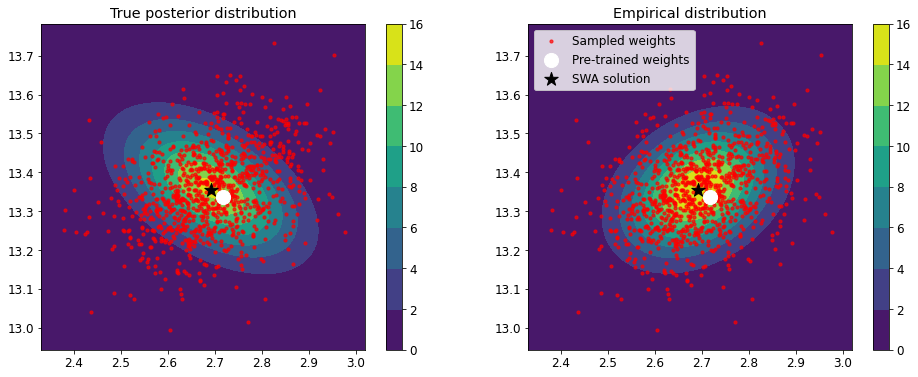

In [101]:
def plot_pdf(W: np.ndarray, mean: np.ndarray, covar: np.ndarray, w_pretrained: np.ndarray, w_swa: np.ndarray, 
             ax: Axes, title: str):
    plt.rcParams.update({'font.size': 12})
    
    w1, w2 = W[:, 0], W[:, 1]

    border = 0.05
    x_max = max(w1.max(), w_pretrained[0]) + border
    x_min = min(w1.min(), w_pretrained[0]) - border

    y_max = max(w2.max(), w_pretrained[1]) + border
    y_min = min(w2.min(), w_pretrained[1]) - border

    X, Y = np.mgrid[x_min:x_max:.01, y_min:y_max:.01]
    pos = np.dstack((X, Y))
    rv = multivariate_normal(mean, covar)
    c = ax.contourf(X, Y, rv.pdf(pos))
    plt.colorbar(c, ax=ax)

    ax.scatter(w1, w2, color='red', s=10, alpha=0.7, label='Sampled weights')
    
    ax.scatter(w_pretrained[0], w_pretrained[1], marker='o', color='white', s=200, label='Pre-trained weights')
    
    ax.scatter(w_swa[0], w_swa[1], marker='*', color='black', s=200, label='SWA solution')
    
    ax.set_title(title)
    

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plot_pdf(W, true_posterior_mean, true_posterior_covar, w_pretrained, empirical_mean, axes[0], 'True posterior distribution')
plot_pdf(W, empirical_mean, empirical_covar, w_pretrained, empirical_mean, axes[1], 'Empirical distribution')
plt.legend()

png_path = f'../../thesis/plots/linear_model_weight_iterates__lr={swa_lr}__lambda={swa_weight_decay}.png'
plt.savefig(png_path, format='png')

plt.show()